In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model, model_selection, preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from keras import layers
from keras.utils import pad_sequences
#from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


1. This dataset contains tweets, which are binarily classified to being about a real natural disaster or not.

In [17]:
#Load train and test datasets
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
print(train_df)
print(test_df)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

The dataset has id, keyword, location and text, with 7612 tweets in train with 3262 tweets in test. keyword and location do not appear to be used, but it will need to be removed when submitting the test dataset prediction.

In [3]:
#count_vectorizer = feature_extraction.text.CountVectorizer()

max_words = 30000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df["text"])

#train_vectors = count_vectorizer.fit_transform(train_df["text"])
#print(tokenizer.shape)
#train_vectors_3D = np.zeros((train_vectors.shape[0],1,train_vectors.shape[1]))
#print(train_vectors_3D.shape)
train_vectors = tokenizer.texts_to_sequences(train_df["text"])
#for i in range(train_vectors_3D.shape[0]):
#    for j in range(train_vectors_3D.shape[2]):
#        train_vectors_3D[i,0,j] = train_vectors[i,j]
#train_vectors_modified = [train_vectors, None]
#for i in range(train_vectors.shape[0]):
#    train_vectors_modified[i] = train_vectors[i]

test_vectors = tokenizer.texts_to_sequences(test_df["text"])
#test_vectors = count_vectorizer.transform(test_df["text"])
#test_vectors_3D = np.zeros((test_vectors.shape[0],1,test_vectors.shape[1]))
#print(test_vectors_3D.shape)
#for i in range(test_vectors_3D.shape[0]):
#    for j in range(test_vectors_3D.shape[2]):
#        test_vectors_3D[i,0,j] = test_vectors[i,j]
#test_vectors = test_vectors.reshape(test_vectors.shape[0], 1, test_vectors.shape[1])

2. In order to properly assess, all sequences must be padded to the same length. To do so, we will first see what the longest sequence in test_vectors is.

In [19]:
max_len = 0
min_len = 100
for i in range(len(train_vectors)):
    max_len = max(np.size(train_vectors[i]),max_len)
    min_len = min(np.size(train_vectors[i]),min_len)
#print(np.size(train_vectors))
print('Max sequence length = ' + str(max_len))
print('Min sequence length = ' + str(min_len))
#print(train_vectors.shape)
#print(train_vectors[0].todense())

#print(train_vectors_modified.todense().shape)
#print(train_vectors_modified.shape)
#print(train_vectors_modified[0].todense())

Max sequence length = 33
Min sequence length = 1


Now that max_sequence length has been determined to be 33, we will pad each sequence to have a length of 33. None of the datasets contaon 0 words, so all of the can be included.

In [5]:
train_padded = pad_sequences(train_vectors, maxlen=max_len)
test_padded = pad_sequences(test_vectors, maxlen=max_len)

I will go through SimpleRNN, LSTM, and GRU over ~50 epochs to see if validation loss hits a minimum. Based on the behavior, I may mess with the number of epochs, learning weight, or batch size to attempt to improve the model. Once I determine what the best val_loss is, I will use that model to predict test images.

In [6]:
#Built using guide from https://www.tensorflow.org/guide/keras/working_with_rnns
model_SimpleRNN = keras.Sequential()
#model_SimpleRNN = keras.Sequential([layers.Embedding(input_dim=21637, output_dim = 64), layers.SimpleRNN(7613, return_sequences=True), layers.Dense(1)])
model_SimpleRNN.add(layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model_SimpleRNN.add(layers.SimpleRNN(64))
model_SimpleRNN.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Embedding(input_dim=21637))

#np.reshape(train_vectors, (train_vectors[0], 1, train_vectors.shape[1]))

model_SimpleRNN.summary()
model_SimpleRNN.compile(loss=keras.losses.binary_crossentropy, optimizer='sgd',metrics=['accuracy'])
y_true_train = train_df['target']
#y_true_train_resize = []
#for i in range(len(y_true_train)):
#    y_true_train_resize.append([1, y_true_train])
model_SimpleRNN.fit(x=train_padded, y = train_df['target'], epochs=50, batch_size = 128, validation_split = 0.25, shuffle=True, callbacks=tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/SimpleRNN_{epoch:02d}-{val_loss:.2f}.keras'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5160 - loss: 0.6939 - val_accuracy: 0.5525 - val_loss: 0.6833
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5739 - loss: 0.6745 - val_accuracy: 0.5604 - val_loss: 0.6722
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5849 - loss: 0.6680 - val_accuracy: 0.5683 - val_loss: 0.6652
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5990 - loss: 0.6611 - val_accuracy: 0.5793 - val_loss: 0.6593
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6055 - loss: 0.6557 - val_accuracy: 0.6523 - val_loss: 0.6460
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6315 - loss: 0.6468 - val_accuracy: 0.6476 - val_loss: 0.6418
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6239 - loss: 0.6491 - val_accuracy: 0.6623 - val_loss: 0.6353
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6296 - loss: 0.6431 - val_accuracy: 0.6460 - v

It is shown that the validation loss flucuates after 12 epochs, so I will schedule learning rate to attempt to stabalize it after 12 epochs.

In [7]:
def scheduler(epoch, lr):
    if epoch < 12:
        return lr
    else:
        return lr*np.exp(-0.1*(epoch-7))

callback = keras.callbacks.LearningRateScheduler(scheduler)

model_SimpleRNN_lrs = keras.Sequential()
#model_SimpleRNN = keras.Sequential([layers.Embedding(input_dim=21637, output_dim = 64), layers.SimpleRNN(7613, return_sequences=True), layers.Dense(1)])
model_SimpleRNN_lrs.add(layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model_SimpleRNN_lrs.add(layers.SimpleRNN(64))
model_SimpleRNN_lrs.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Embedding(input_dim=21637))

#np.reshape(train_vectors, (train_vectors[0], 1, train_vectors.shape[1]))

model_SimpleRNN_lrs.summary()
model_SimpleRNN_lrs.compile(loss=keras.losses.binary_crossentropy, optimizer='sgd',metrics=['accuracy'])
y_true_train = train_df['target']
#y_true_train_resize = []
#for i in range(len(y_true_train)):
#    y_true_train_resize.append([1, y_true_train])
model_SimpleRNN_lrs.fit(x=train_padded, y = train_df['target'], epochs=50, batch_size = 128, validation_split = 0.25, callbacks=[callback], shuffle=True)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5697 - loss: 0.6821 - val_accuracy: 0.5457 - val_loss: 0.6774 - learning_rate: 0.0100
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5818 - loss: 0.6675 - val_accuracy: 0.6077 - val_loss: 0.6619 - learning_rate: 0.0100
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5985 - loss: 0.6620 - val_accuracy: 0.6203 - val_loss: 0.6529 - learning_rate: 0.0100
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6192 - loss: 0.6515 - val_accuracy: 0.5951 - val_loss: 0.6539 - learning_rate: 0.0100
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6259 - loss: 0.6478 - val_accuracy: 0.6507 - val_loss: 0.6401 - learning_rate: 0.0100
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6301 - loss: 0.6468 - val_accuracy: 0.6534 - val_loss: 0.6358 - learning_rate: 0.0100
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6318 - loss: 0.6443 - val_acc

It appears the validation accuracy becomes steady around 30 epochs, but training is short so we'll continue to train 50 epochs. I will now test LSTM and GRU methods against simple RNN.

In [8]:
#LSTM Model
model_LSTM_lrs = keras.Sequential()
#model_SimpleRNN = keras.Sequential([layers.Embedding(input_dim=21637, output_dim = 64), layers.SimpleRNN(7613, return_sequences=True), layers.Dense(1)])
model_LSTM_lrs.add(layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model_LSTM_lrs.add(layers.LSTM(64))
model_LSTM_lrs.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Embedding(input_dim=21637))

#np.reshape(train_vectors, (train_vectors[0], 1, train_vectors.shape[1]))

model_LSTM_lrs.summary()
model_LSTM_lrs.compile(loss=keras.losses.binary_crossentropy, optimizer='adam',metrics=['accuracy'])
y_true_train = train_df['target']
#y_true_train_resize = []
#for i in range(len(y_true_train)):
#    y_true_train_resize.append([1, y_true_train])
model_LSTM_lrs.fit(x=train_padded, y = train_df['target'], epochs=50, batch_size = 128, validation_split = 0.25, callbacks=[callback], shuffle=True)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5766 - loss: 0.6693 - val_accuracy: 0.7227 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7799 - loss: 0.4849 - val_accuracy: 0.7857 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9143 - loss: 0.2441 - val_accuracy: 0.7742 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9509 - loss: 0.1480 - val_accuracy: 0.7663 - val_loss: 0.5833 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9705 - loss: 0.0900 - val_accuracy: 0.7568 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9811 - loss: 0.0554 - val_accuracy: 0.7311 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9870 - loss: 0.0433 - val_acc

LSTM validation loss was minimized after 3 epochs, so I will train it to only 3 epochs

In [12]:
#LSTM Model
model_LSTM_lrs = keras.Sequential()
#model_SimpleRNN = keras.Sequential([layers.Embedding(input_dim=21637, output_dim = 64), layers.SimpleRNN(7613, return_sequences=True), layers.Dense(1)])
model_LSTM_lrs.add(layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model_LSTM_lrs.add(layers.LSTM(64))
model_LSTM_lrs.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Embedding(input_dim=21637))

#np.reshape(train_vectors, (train_vectors[0], 1, train_vectors.shape[1]))

model_LSTM_lrs.summary()
model_LSTM_lrs.compile(loss=keras.losses.binary_crossentropy, optimizer='adam',metrics=['accuracy'])
y_true_train = train_df['target']
#y_true_train_resize = []
#for i in range(len(y_true_train)):
#    y_true_train_resize.append([1, y_true_train])
model_LSTM_lrs.fit(x=train_padded, y = train_df['target'], epochs=3, batch_size = 128, validation_split = 0.25, callbacks=[callback], shuffle=True)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5825 - loss: 0.6667 - val_accuracy: 0.7279 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 2/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7944 - loss: 0.4730 - val_accuracy: 0.7784 - val_loss: 0.4614 - learning_rate: 0.0010
Epoch 3/3
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9049 - loss: 0.2569 - val_accuracy: 0.7726 - val_loss: 0.5008 - learning_rate: 0.0010


This method has a smaller val_loss. I will now train on a GRU and compare it to this result

In [13]:
#GRU  Model
model_GRU = keras.Sequential()
#model_SimpleRNN = keras.Sequential([layers.Embedding(input_dim=21637, output_dim = 64), layers.SimpleRNN(7613, return_sequences=True), layers.Dense(1)])
model_GRU.add(layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model_GRU.add(layers.GRU(64, recurrent_dropout=0.2))
model_GRU.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Embedding(input_dim=21637))

#np.reshape(train_vectors, (train_vectors[0], 1, train_vectors.shape[1]))

model_GRU.summary()
model_GRU.compile(loss=keras.losses.binary_crossentropy, optimizer='adam',metrics=['accuracy'])
y_true_train = train_df['target']
#y_true_train_resize = []
#for i in range(len(y_true_train)):
#    y_true_train_resize.append([1, y_true_train])
model_GRU.fit(x=train_padded, y = train_df['target'], epochs=50, batch_size = 128, validation_split = 0.25)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.5890 - loss: 0.6692 - val_accuracy: 0.7001 - val_loss: 0.6070
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7739 - loss: 0.4990 - val_accuracy: 0.7285 - val_loss: 0.5563
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9037 - loss: 0.2703 - val_accuracy: 0.7269 - val_loss: 0.5485
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9506 - loss: 0.1419 - val_accuracy: 0.7274 - val_loss: 0.5630
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9778 - loss: 0.0755 - val_accuracy: 0.7195 - val_loss: 0.5935
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9860 - loss: 0.0437 - val_accuracy: 0.7022 - val_loss: 0.6536
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9893 - loss: 0.0382 - val_accuracy: 0.7027 - val_loss: 0.6609
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9927 - loss: 0.0269 - val_accuracy: 0.7033 - v

Since GRU val_loss also increased, I will set epochs to 3 like the LSTM model.

In [15]:
#GRU  Model
model_GRU = keras.Sequential()
#model_SimpleRNN = keras.Sequential([layers.Embedding(input_dim=21637, output_dim = 64), layers.SimpleRNN(7613, return_sequences=True), layers.Dense(1)])
model_GRU.add(layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model_GRU.add(layers.GRU(64, recurrent_dropout=0.2))
model_GRU.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Embedding(input_dim=21637))

#np.reshape(train_vectors, (train_vectors[0], 1, train_vectors.shape[1]))

model_GRU.summary()
model_GRU.compile(loss=keras.losses.binary_crossentropy, optimizer='adam',metrics=['accuracy'])
y_true_train = train_df['target']
#y_true_train_resize = []
#for i in range(len(y_true_train)):
#    y_true_train_resize.append([1, y_true_train])
model_GRU.fit(x=train_padded, y = train_df['target'], epochs=3, batch_size = 64, validation_split = 0.25)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6007 - loss: 0.6608 - val_accuracy: 0.7442 - val_loss: 0.5768
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8493 - loss: 0.3759 - val_accuracy: 0.7500 - val_loss: 0.5294
Epoch 3/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9385 - loss: 0.1825 - val_accuracy: 0.7227 - val_loss: 0.5659


In terms of val_loss, GRU outperforms simpleRNN but not as well as the LSTM model. I will therefore use LSTM to predict the test dataset.

In [16]:
y_pred = model_LSTM_lrs.predict(test_padded)

test_df['y_pred'] = (y_pred >= 0.5).astype(int)
print(test_df.head())

test_df.to_csv("submission.csv", index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires   
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan   

   y_pred  
0       1  
1       1  
2       1  
3       1  
4       1  


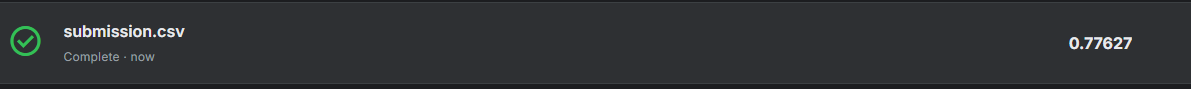

The test dataset was approximatly as accurate as the validation dataset was.

One of the interesting things about this project is that I did try reducing batch_size to increase accuracy, but it actually had an inverse effect on val_accuracy. I believe the model was overfitting on the training dataset, and therefore did not have the effect I thought it would.